In [8]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

# Computing the spectral decomposition using the FFT

In [309]:
domain = jnp.array([0,1])

In [310]:
l,k = 1,1
f = lambda x:  0.5*jnp.sqrt(2)*jnp.cos(jnp.pi*l*x) +  2*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)

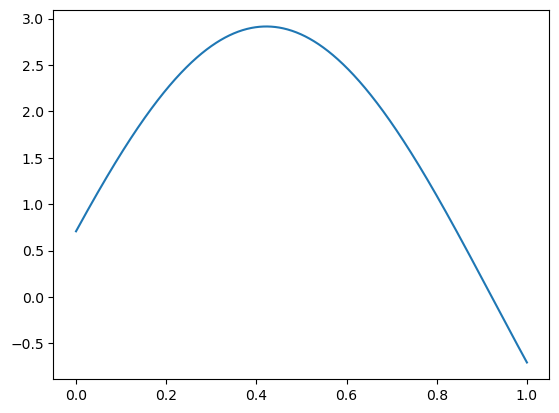

In [311]:
n_points = 2**10
grid = jnp.linspace(domain[0], domain[1], n_points)
y_values = f(grid)
plt.plot(grid, y_values)

In [312]:
y_dilated = jnp.hstack([f(grid), -f(grid)]) # We need to dilate because we want the half period to be 1
alpha = fft.fft(y_dilated)

In [313]:
def get_cos_sin_coef(alpha):
    n = alpha.shape[0]
    c = alpha[0].real/n
    a = jnp.sqrt(2)*alpha.real/n
    b = -jnp.sqrt(2)*alpha.imag/n
    return a, b, c

In [314]:
a,b, c = get_cos_sin_coef(alpha)
c, a[l], b[k] # We get good recovery of the coefficients

(Array(0., dtype=float64),
 Array(0.50330994, dtype=float64),
 Array(1.99825246, dtype=float64))

## Evaluate on the real domain

In [315]:
def evaluate_real_domain(a,b):
    n = len(a)
    return fft.ifft((a - 1j*b)*n/jnp.sqrt(2)).real

f_eval_dilated = evaluate_real_domain(a,b)

In [356]:
a_test = jnp.zeros(n_points, dtype=jnp.float64)
b_test = jnp.zeros(n_points, dtype=jnp.float64)
a_test = a_test.at[l].set(0.5)*2
b_test = b_test.at[k].set(2)*2
#a_test = jnp.hstack([a_test, -a_test])
#b_test = jnp.hstack([b_test, -b_test])

f_eval_test = evaluate_real_domain(a_test,b_test)

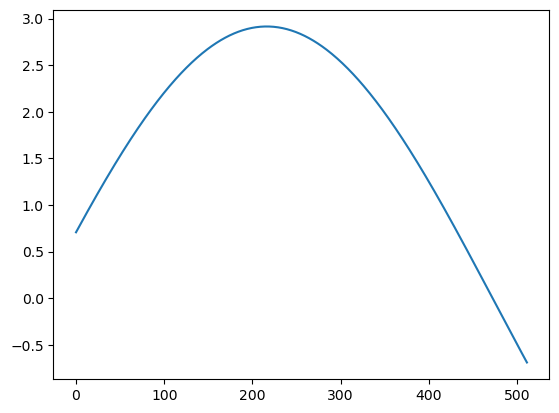

In [357]:
plt.plot( f_eval_test[:n_points//2], label='f_eval_test')

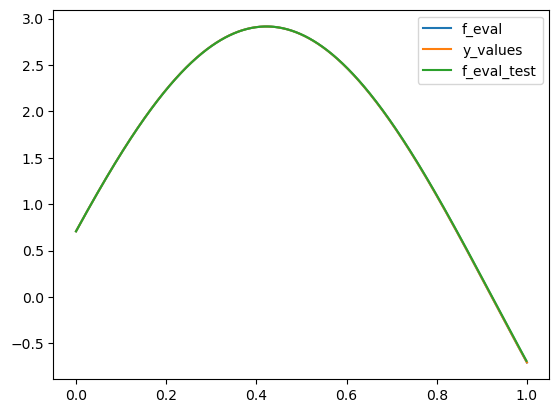

In [359]:
plt.plot(grid, f_eval_dilated[:n_points], label='f_eval')
plt.plot(grid, y_values, label='y_values')
#plt.plot(grid, f_eval_test, label='f_eval_test')
plt.plot(grid[::2], f_eval_test[:n_points//2], label='f_eval_test')
plt.legend()

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Iou casem we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}


In [139]:
key = random.PRNGKey(0)

n_coef = 5000
coef_f = random.normal(key, shape= (n_coef,))
# We pad the coefficients with a zero
c = 0.0 # constant
coef_f_pad = jnp.hstack([jnp.zeros(1)+ 2*c, coef_f])
coef_f_cos =  jnp.hstack([jnp.zeros(1)+ 2*c,jnp.zeros(n_coef)])

In [140]:
lower = 0.0
upper = 1.0

In [141]:
f_values_dilated =  evaluate_real_domain(coef_f_cos,coef_f_pad)

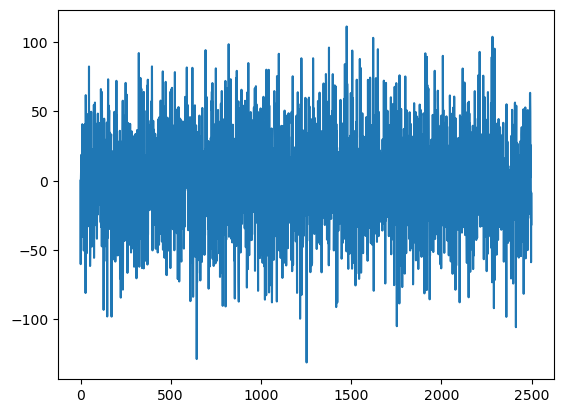

In [145]:
plt.plot(f_values_dilated[:n_coef//2])

In [36]:
# Spectral method 
nu = 0.01
coef_u = coef_f_pad/(nu*jnp.pi*jnp.arange(n_coef+1)**2 + 1)

In [37]:
u_values = evaluate_real_domain(coef_f_cos,coef_u)*jnp.sqrt(2)

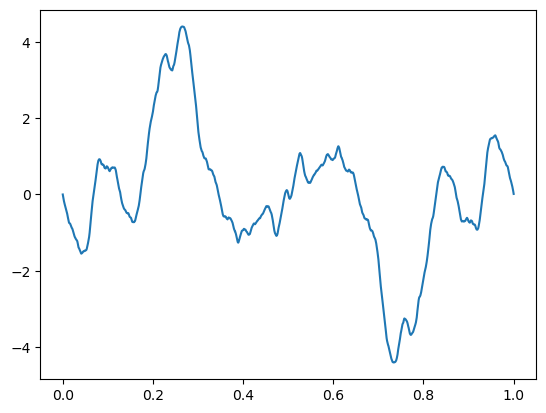

In [38]:
plt.plot(jnp.linspace(0,1,n_coef+1), u_values)
plt.show()

## Kernel method with FFT
We need to compute 

$$
\Theta = \begin{bmatrix}
K(X_{\partial\Omega},X_{\partial\Omega}) & \int L_y K(X_{\partial\Omega}, y)\varphi(y) \\
\int L_y K(X_{\partial\Omega}, y)\varphi(y) ^\intercal & \int \int  L_y L_x K( x, y) \varphi(x)\varphi(y)
\end{bmatrix}
$$

We need to calculate

$$
\int \int \varphi_i(x)\varphi_j(y)L_y L_x K(x,y) dx dy
$$
where the $\varphi$ are the Fourier basis functions. 

We will do so by using the FFT
$$
\int \int \varphi_i(x)\varphi_j(y)L_y L_x K(x,y) dx dy \approx \mathcal{F}_y \mathcal{F}_x L_y L_x K(x,y)
$$

For this we need to evaluate $G(x,y) := \mathcal{F}_y \mathcal{F}_x L_y L_x K(x,y)$ on a grid and apply the FFT seperately to each dimension

In [169]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y

In [170]:
b =lambda x : jnp.ones_like(x)*1.0
length_scale = 1.0
upper = jnp.array([1.0])
lower = jnp.array([0.0])
boundary = jnp.hstack([lower, upper])

In [171]:
domain.shape

(501,)

In [172]:
def get_cos_sin_coef(alpha):
    n = alpha.shape[0]
    c = alpha[0].real/n
    a = 2*alpha.real/n
    b = -2*alpha.imag/n
    return a, b, c

In [181]:
n_meas = 500
domain = jnp.linspace(0,1,n_meas+1) # We add a point because we do not want the constant
#theta_22 = vmap_kernel(domain, domain, length_scale)
theta_22 = vmap_L_b_xy(domain, domain, length_scale,nu, b(domain), b(domain))

# Apply the fft to the first axis
theta_22_fft = fft.fft(theta_22, axis =0)
# Extract the sine coefficients
theta_22_fft = jnp.sqrt(2)*theta_22_fft.imag/(n_meas + 1)
# Apply the fft to the second axis
theta_22_fft = fft.fft(theta_22_fft, axis =1)
# Extract the sine coefficients
theta_22_sine = jnp.sqrt(2)*theta_22_fft.imag/(n_meas + 1)

# Check that the matrix is PSD 
jnp.linalg.eigh(theta_22_sine)[0][0]

Array(-2.07177975e-17, dtype=float64)

In [186]:
# Manually check the entries
k,l = 3,5
print(theta_22_sine[k,l])

# Manually computing the integral
G = theta_22*jnp.outer(jnp.sqrt(2)*jnp.sin(2*jnp.pi*k*domain), jnp.sqrt(2)*jnp.sin(2*jnp.pi*l*domain))
integral = integrate.trapezoid(integrate.trapezoid(G, domain), domain)
integral

0.00357353418687194


0.0035652787527346765

In [118]:
# def fourier_transform_matrix(N):
#     # Create a matrix of indices
#     j = jnp.arange(N).reshape((N, 1))
#     k = jnp.arange(N).reshape((1, N))
    
#     # Compute the Fourier transform matrix
#     omega = jnp.exp(-2j * jnp.pi / N)
#     F = omega ** (j * k)
    
#     return F

# F = fourier_transform_matrix(n_meas+1)
# theta_22_fft_manual = F.conjugate()@((F.conjugate()@theta_22).conjugate().T)

In [185]:
# Testing the above code with pure sine functions
k,l= 10, 19
f = lambda x,y: jnp.sqrt(2)*jnp.sin(2*jnp.pi*k*y)*jnp.sqrt(2)*jnp.sin(2*jnp.pi*l*x)
test = vmap(vmap(f, in_axes =(0, None)), in_axes= (None, 0))(domain, domain)

test_fft = fft.fft(test, axis =0)
# Extract the sine coefficients
test_fft = jnp.sqrt(2)*test_fft.imag/(n_meas + 1)
# Apply the fft to the second axis
test_fft = fft.fft(test_fft, axis =1)
# Extract the sine coefficients
test_fft =  jnp.sqrt(2)*test_fft.imag/(n_meas + 1)

print(test_fft[k,l])
G=test*jnp.outer(jnp.sqrt(2)*jnp.sin(2*jnp.pi*k*domain), jnp.sqrt(2)*jnp.sin(2*jnp.pi*l*domain))
print(integrate.trapezoid(integrate.trapezoid(G, domain), domain))

k, l = k-2, l-2
print(test_fft[k,l])
G=test*jnp.outer(jnp.sqrt(2)*jnp.sin(2*jnp.pi*(k)*domain), jnp.sqrt(2)*jnp.sin(2*jnp.pi*(l)*domain))
print(integrate.trapezoid(integrate.trapezoid(G, domain), domain))

0.9859720516661111
1.0000000000000004
0.0001529996478410194
-3.748086910280086e-19


## Solving the PDE

In [ ]:
# Using the FT

xi = 

# A 2D example

In [525]:
j,k= 1,5
m,n = 2,4
f = lambda x,y: jnp.cos(2*jnp.pi*(j*x + k*y)) + 4.12*jnp.sin(2*jnp.pi*(m*x + n*y))

In [526]:
domain = jnp.array([0,1])

# 2d grid 
x = jnp.linspace(domain[0], domain[1], n_points)
y = jnp.linspace(domain[0], domain[1], n_points)
X, Y = jnp.meshgrid(x, y)

In [527]:
values = f(X,Y)

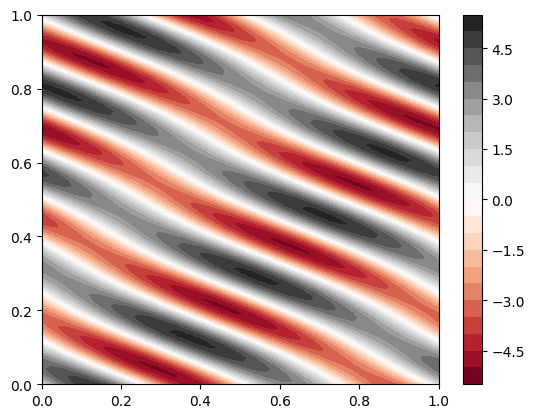

In [528]:
# 2D plot
plt.contourf(X, Y, values, 20, cmap='RdGy')
plt.colorbar()

In [529]:
alpha = fft.fft2(values)

In [530]:
def get_cos_sin_coef_2d(alpha):
    n = alpha.shape[0]
    m = alpha.shape[1]
    c = alpha[0,0].real/(n*m)
    a = 2*alpha.real/(n*m)
    b = -2*alpha.imag/(n*m)
    return a, b, c


In [531]:
a, b, c = get_cos_sin_coef_2d(alpha)

In [532]:
def evaluate_real_domain(a,b):
    m,n = a.shape
    return fft.ifftn((a - 1j*b)*(m*n)/2).real

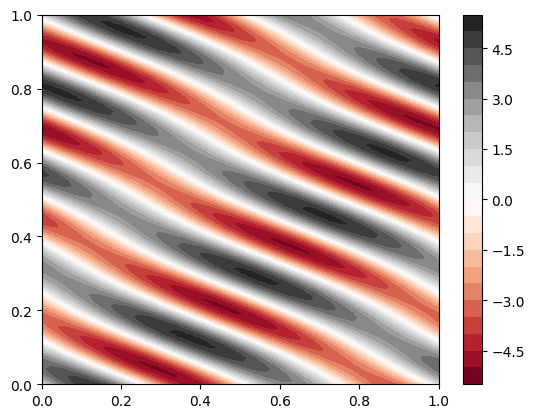

In [533]:
f_eval = evaluate_real_domain(a,b)
# 2D plot
plt.contourf(X, Y, f_eval, 20, cmap='RdGy')
# colorbar
plt.colorbar()

In [534]:
jnp.mean(jnp.abs(f_eval - values))

Array(6.91410817e-16, dtype=float64)

In [535]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [559]:
a_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)
b_test = jnp.zeros((n_points,n_points), dtype=jnp.float64)  

a_test = a_test.at[k,j].set(1)
b_test = b_test.at[n,m].set(2)*4.12

In [564]:
a[k,j], b[n,m]

(Array(0.97736724, dtype=float64), Array(4.0334417, dtype=float64))

In [560]:
f_eval_test = evaluate_real_domain(a_test,b_test)
jnp.mean(jnp.abs(f_eval_test - values))

Array(0.56350486, dtype=float64)

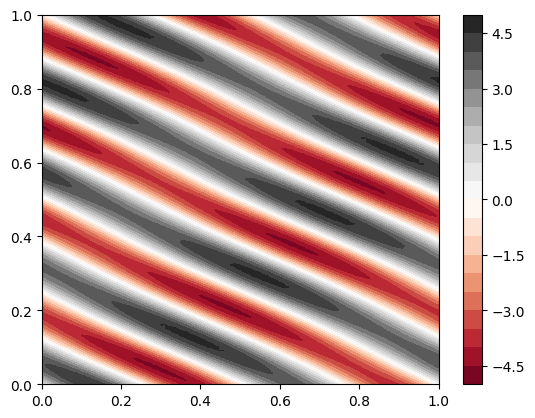

In [561]:
plt.contourf(X, Y, f_eval_test, 20, cmap='RdGy')
# colorbar
plt.colorbar()

# Elliptic equation in 1D
We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

